In [1]:
import torch
import pickle
import random
import matplotlib.pyplot as plt
import numpy as np
import torchsummary
import importlib as imp

import data_loader.data_loader as data_loader
from trainer.trainer import Trainer
from model.model import TorchModel
from utils import prepare_device
from model.loss import GaussianNLL, ShashNLL

torch.set_warn_always(False)

# https://github.com/victoresque/pytorch-template/tree/master

# TODO: code up shash
# TODO: add a logger
# TODO: add metrics
# TODO: change from settings to config files

In [ ]:
settings = {
    "batch_size": 32,
    "device": "gpu",
    "max_epochs": 10_000,
    "learning_rate": 0.00001,
    "patience": 2,
    "min_delta": 0.05,
    "criterion": ShashNLL(),
}

In [ ]:
trainset = data_loader.CustomData("data/train_data.pickle")
valset = data_loader.CustomData("data/val_data.pickle")
train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=settings["batch_size"], shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    valset, batch_size=settings["batch_size"], shuffle=False
)


In [ ]:
SEED = 44
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True


trainset = data_loader.CustomData("data/train_data.pickle")
valset = data_loader.CustomData("data/val_data.pickle")
train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=settings["batch_size"], shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    valset, batch_size=settings["batch_size"], shuffle=False
)

model = TorchModel(target=trainset.target)
# torchsummary.summary(model, [trainset.input[0].shape, trainset.input_unit[0][np.newaxis, np.newaxis, np.newaxis].shape])

device = prepare_device(settings["device"])
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=settings["learning_rate"])

trainer = Trainer(
    model,
    settings["criterion"],
    optimizer,
    max_epochs=settings["max_epochs"],
    device=device,
    data_loader=train_loader,
    validation_data_loader=val_loader,
    settings=settings,
)

/opt/homebrew/Caskroom/miniforge/base/envs/env-torch-sonoma/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
trainer.fit()

Epoch   0/10000
  9.2s - train_loss: 1.36000 - val_loss: 1.31688
Epoch   1/10000
  8.3s - train_loss: 1.31893 - val_loss: 1.29012
Restoring model weights from the end of the best epoch 0: val_loss = 1.31688


In [ ]:
input = torch.Tensor(valset.input[:3]).to(device)
input_unit = torch.Tensor(valset.input_unit[:3]).to(device)
with torch.no_grad():
  pred = model(input, input_unit)
pred = pred.cpu().numpy()
pred

array([[ 1.5274987 ,  1.0101194 , -0.24972615,  1.        ],
       [ 1.5281193 ,  1.0087178 , -0.25303507,  1.        ],
       [ 1.5300001 ,  1.0101832 , -0.2542516 ,  1.        ]],
      dtype=float32)

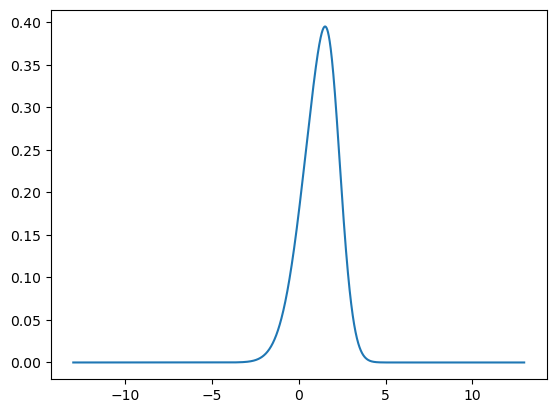

In [ ]:
from shash.shash_torch import Shash

sample = 1
x = np.arange(-13,13,.01)
dist = Shash(mu=pred[sample,0], sigma=pred[sample,1], gamma=pred[sample,2], tau=pred[sample,3])
p = dist.prob(torch.tensor(x))

plt.plot(x, p)